In [ ]:
!pip install langchain
!pip install langchain_community
!pip install chromadb
!pip install -Uq lark
!pip install wikipedia
!pip install tiktoken

In [ ]:
# api key和模型名称
openai_api_key = 'your api key'
model_name = 'gpt-3.5-turbo'

# 2.2 模型、提示和解析器

提示

In [ ]:
from langchain.prompts import ChatPromptTemplate

# step1：构造一个提示模版字符串
prompt_template_str = """请把下面三个反引号分隔的文本转换成{style}的风格。\
文本: ```{text}```
"""

# step2：构造提示模板
prompt_template = ChatPromptTemplate.from_template(prompt_template_str)

# step3：使用提示模板
user_comment = """
上次我在你们店铺买了一双鞋子，结果到货后竟然发现一只白的，一直黑的，简直不敢相信，没见过这么马虎的，太让人生气了。我现在要求退货。
"""
style = """
温和、谦逊
"""
user_messages = prompt_template.format_messages(style=style, text=user_comment)
user_messages[0]

HumanMessage(content='请把下面三个反引号分隔的文本转换成\n温和、谦逊\n的风格。文本: ```\n上次我在你们店铺买了一双鞋子，结果到货后竟然发现一只白的，一直黑的，简直不敢相信，没见过这么马虎的，太让人生气了。我现在要求退货。\n```\n', additional_kwargs={}, response_metadata={})

模型

In [ ]:
from langchain.chat_models import ChatOpenAI

chat = ChatOpenAI(model_name=model_name, temperature=0.0, openai_api_key=openai_api_key)
response = chat(user_messages)
response.content

'亲爱的店主，之前我在您的店铺购买了一双鞋子，但收到货物后发现一只是白色的，另一只是黑色的，实在让我感到惊讶。这样的疏忽让我有些生气，我想申请退货。希望您能理解我的情况，谢谢。'

解析

In [ ]:
from langchain.prompts import ChatPromptTemplate
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

text = """
1609年9月11日，受聘于荷兰东印度公司的英国航海家亨利·哈德逊（Henry Hudson）乘船来到今纽约州探险，\
并将大量土产带回荷兰，许多荷兰商人对这片土地产生了浓厚兴趣，他们来到这里寻求与当地原住民进行贸易，\
并建立了殖民地“新荷兰”（New Netherland）。荷兰殖民者于1614年在新荷兰建立贸易点Fort Nassau（今奥尔巴尼市附近）；\
于1624年建立贸易点Fort Orange（今奥尔巴尼市）；于1625年建立贸易点Fort Amsterdam（今纽约市）。
"""

# step1：编写提示。
prompt_template_str = """
请从以下```包括的内容中提取以下信息。
姓名：提取所有的姓名，并将它们输出为逗号分隔的Python列表, 如果没有找到该信息，则输出none。
城市：提取所有的城市名称，并将它们输出为逗号分隔的Python列表, 如果没有找到该信息，则输出none。

文本: {text}
{format_instructions}
"""

# step2：依据输出结构构造标准化输出模式类（ResponseSchema）与解析类（StructuredOutputParser）。
name_schema = ResponseSchema(name="姓名",
                description="提取所有的姓名，并将它们输出为逗号分隔的Python列表, 如果没有找到该信息，则输出none。")

city_schema = ResponseSchema(name="城市",
                description="提取所有的城市名称，并将它们输出为逗号分隔的Python列表, 如果没有找到该信息，则输出none。")
response_schemas = [name_schema, city_schema]
output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

# step3：依据StructuredOutputParser生成完整的提示。
format_instructions = output_parser.get_format_instructions()
prompt_template = ChatPromptTemplate.from_template(template=prompt_template_str)
user_messages = prompt_template.format_messages(text=text, format_instructions=format_instructions)
print('提示：', user_messages[0])


# step4：完整的提示送入大模型返回结果。
response = chat(user_messages)
print("结果:", response.content)

# step5：依据StructuredOutputParser对输出的结果进行解析。
response_dict = output_parser.parse(response.content)
print("解析后类型:", type(response_dict))
print("解析后内容:", response_dict)


提示： content='\n请从以下```包括的内容中提取以下信息。\n姓名：提取所有的姓名，并将它们输出为逗号分隔的Python列表, 如果没有找到该信息，则输出none。\n城市：提取所有的城市名称，并将它们输出为逗号分隔的Python列表, 如果没有找到该信息，则输出none。\n\n文本: \n1609年9月11日，受聘于荷兰东印度公司的英国航海家亨利·哈德逊（Henry Hudson）乘船来到今纽约州探险，并将大量土产带回荷兰，许多荷兰商人对这片土地产生了浓厚兴趣，他们来到这里寻求与当地原住民进行贸易，并建立了殖民地“新荷兰”（New Netherland）。荷兰殖民者于1614年在新荷兰建立贸易点Fort Nassau（今奥尔巴尼市附近）；于1624年建立贸易点Fort Orange（今奥尔巴尼市）；于1625年建立贸易点Fort Amsterdam（今纽约市）。\n\nThe output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":\n\n```json\n{\n\t"姓名": string  // 提取所有的姓名，并将它们输出为逗号分隔的Python列表, 如果没有找到该信息，则输出none。\n\t"城市": string  // 提取所有的城市名称，并将它们输出为逗号分隔的Python列表, 如果没有找到该信息，则输出none。\n}\n```\n' additional_kwargs={} response_metadata={}
结果: ```json
{
	"姓名": ["亨利·哈德逊"],
	"城市": ["纽约州", "奥尔巴尼市", "纽约市"]
}
```
解析后类型: <class 'dict'>
解析后内容: {'姓名': ['亨利·哈德逊'], '城市': ['纽约州', '奥尔巴尼市', '纽约市']}


# 2.3 记忆机制

对话缓存储存 (ConversationBufferMemory）

In [ ]:
from langchain.chains import ConversationChain
from langchain.chat_models import ChatOpenAI
from langchain.memory import ConversationBufferMemory

llm = ChatOpenAI(model_name=model_name, temperature=0.0, openai_api_key=openai_api_key)
memory = ConversationBufferMemory()
conversation_chain = ConversationChain(llm=llm, memory=memory, verbose=True)

In [ ]:
conversation_chain.predict(input="what is my name?")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: my name is jack
AI: Hello Jack! It's nice to meet you. How can I assist you today?
Human: what is the result of 1 plus 1?
AI: The result of 1 plus 1 is 2. This is a basic arithmetic operation where you add the two numbers together to get the sum. Is there anything else you would like to know?
Human: what is my name?
AI:

> Finished chain.


'Your name is Jack. You mentioned it at the beginning of our conversation. Is there anything else you would like to ask, Jack?'

对话缓存窗口储存 (ConversationBufferWindowMemory）

In [ ]:
from langchain.memory import ConversationBufferWindowMemory

memory = ConversationBufferWindowMemory(k=2)
conversation_chain = ConversationChain(llm=llm, memory=memory, verbose=True)

print("对话一：")
print(conversation_chain.predict(input="my name is jack"))

print("对话二：")
print(conversation_chain.predict(input="what is the result of 1 plus 1?"))

print("对话三：")
print(conversation_chain.predict(input="what is my name?"))


对话一：


> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: my name is jack
AI:

> Finished chain.
Hello Jack! It's nice to meet you. How can I assist you today?
对话二：


> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: my name is jack
AI: Hello Jack! It's nice to meet you. How can I assist you today?
Human: what is the result of 1 plus 1?
AI:

> Finished chain.
The result of 1 plus 1 is 2. It's a simple addition problem where you add the two 

对话令牌缓存储存

In [ ]:
from langchain.llms import OpenAI
from langchain.memory import ConversationTokenBufferMemory

memory = ConversationTokenBufferMemory(llm=llm, max_token_limit=50)
memory.save_context({"input": "my name is jack"}, {"output": "Hello Jack! It's nice to meet you. How can I assist you today?"})
memory.save_context({"input": "what is the result of 1 plus 1?"}, {"output": "The result of 1 plus 1 is 2. It's a simple addition problem with a straightforward answer. Is there anything else you'd like to know or discuss?"})
memory.load_memory_variables({})

{'history': "AI: The result of 1 plus 1 is 2. It's a simple addition problem with a straightforward answer. Is there anything else you'd like to know or discuss?"}

对话摘要缓存储存

In [ ]:
from langchain.chains import ConversationChain
from langchain.chat_models import ChatOpenAI
from langchain.memory import ConversationSummaryBufferMemory

memory = ConversationSummaryBufferMemory(llm=llm, max_token_limit=70)
memory.save_context({"input": "请给我讲一个探险故事。"}, {"output": "1609年9月11日，受聘于荷兰东印度公司的英国航海家亨利·哈德逊（Henry Hudson）乘船来到今纽约州探险，并将大量土产带回荷兰，许多荷兰商人对这片土地产生了浓厚兴趣，他们来到这里寻求与当地原住民进行贸易，并建立了殖民地“新荷兰”（New Netherland）。荷兰殖民者于1614年在新荷兰建立贸易点Fort Nassau（今奥尔巴尼市附近）；于1624年建立贸易点Fort Orange（今奥尔巴尼市）；于1625年建立贸易点Fort Amsterdam（今纽约市）。"})
memory.save_context({"input": "谢谢您，很好的一个故事。"}, {"output": "不客气，还有什么需要帮助的吗？"})
print(memory.load_memory_variables({})['history'])

System: The human asks the AI to tell an adventure story. The AI recounts the expedition of English navigator Henry Hudson in 1609, who explored what is now New York State and brought back many goods to the Netherlands. This sparked interest among Dutch merchants, leading to the establishment of the colony of New Netherland. The Dutch settlers set up trading posts like Fort Nassau, Fort Orange, and Fort Amsterdam in the region.
Human: 谢谢您，很好的一个故事。
AI: 不客气，还有什么需要帮助的吗？


In [ ]:
conversation = ConversationChain(llm=llm, memory=memory, verbose=True)
conversation.predict(input="亨利·哈德逊是哪一年来到了纽约州进行探险？")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
System: The human asks the AI to tell an adventure story. The AI recounts the expedition of English navigator Henry Hudson in 1609, who explored what is now New York State and brought back many goods to the Netherlands. This sparked interest among Dutch merchants, leading to the establishment of the colony of New Netherland. The Dutch settlers set up trading posts like Fort Nassau, Fort Orange, and Fort Amsterdam in the region.
Human: 谢谢您，很好的一个故事。
AI: 不客气，还有什么需要帮助的吗？
Human: 亨利·哈德逊是哪一年来到了纽约州进行探险？
AI:

> Finished chain.


'亨利·哈德逊是在1609年来到纽约州进行探险的。'

# 2.4 模型链结构

大语言模型链

输入 -》 链 =》 输出

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

llm = ChatOpenAI(model_name=model_name, temperature=0.0, openai_api_key=openai_api_key)
prompt = ChatPromptTemplate.from_template("请用一句话描述算法{algorithm_name}的主要原理。")
chain = LLMChain(llm=llm, prompt=prompt)

In [ ]:
algorithm_name = "gpt"
chain.run(algorithm_name)

'GPT算法的主要原理是基于大规模预训练的神经网络模型，通过自监督学习和迁移学习来生成自然语言文本。'

简单顺序链

输入 -》 链1 =》 链1输出 =》 链2 =》链2输出

In [ ]:
from langchain.chains import SimpleSequentialChain

llm = ChatOpenAI(model_name=model_name, temperature=0.0, openai_api_key=openai_api_key)
# 链1：输入算法名称，输出简要介绍。
first_prompt = ChatPromptTemplate.from_template(
    "请用一句话描述算法{algorithm_name}的主要原理。"
)
chain_one = LLMChain(llm=llm, prompt=first_prompt)

# 链2：输入算法简要介绍，输出英语简要介绍。
second_prompt = ChatPromptTemplate.from_template(
    "请将以下文本翻译成英语，\
    文本：{algorithm_desciption}"
)
chain_two = LLMChain(llm=llm, prompt=second_prompt)
overall_simple_chain = SimpleSequentialChain(chains=[chain_one, chain_two], verbose=True)

In [ ]:
algorithm_name = "gpt"
overall_simple_chain.run(algorithm_name)



> Entering new SimpleSequentialChain chain...
GPT算法的主要原理是基于大规模预训练的神经网络模型，通过自监督学习和迁移学习来生成自然语言文本。
The main principle of the GPT algorithm is based on a large-scale pre-trained neural network model, which generates natural language text through self-supervised learning and transfer learning.

> Finished chain.


'The main principle of the GPT algorithm is based on a large-scale pre-trained neural network model, which generates natural language text through self-supervised learning and transfer learning.'

顺序链



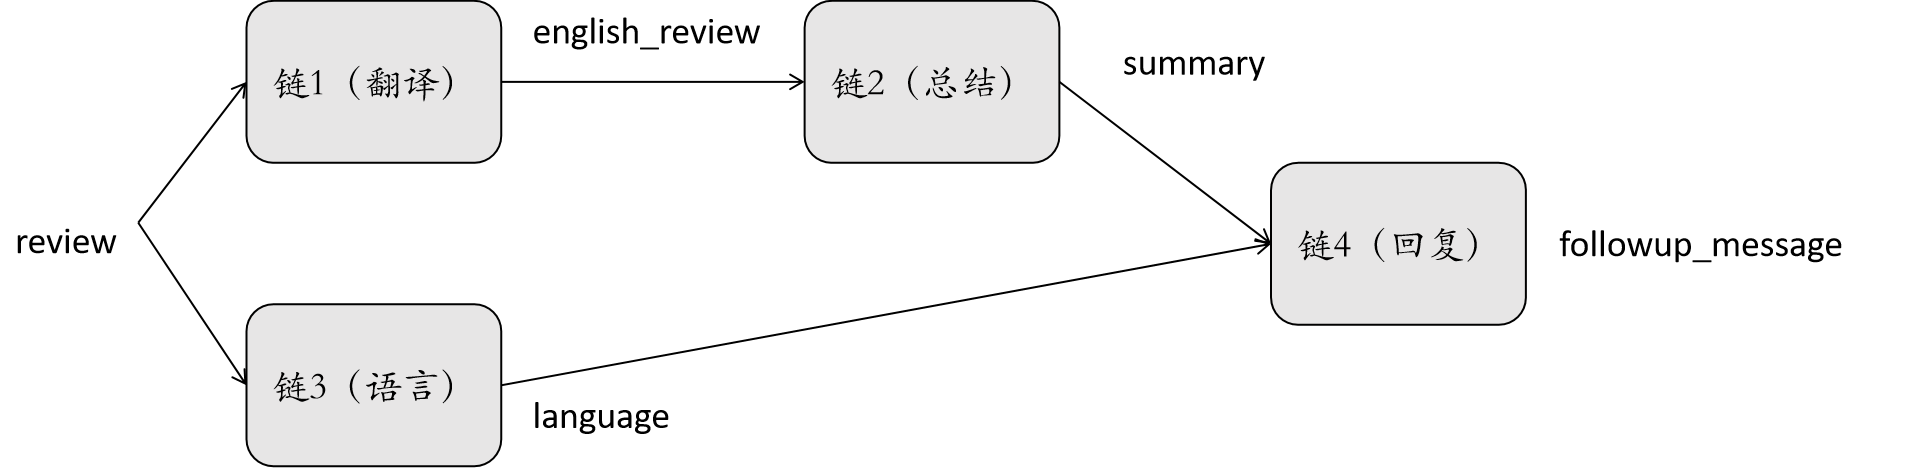

In [ ]:
import pandas as pd
from langchain.chains import SequentialChain
from langchain.chat_models import ChatOpenAI    #导入OpenAI模型
from langchain.prompts import ChatPromptTemplate   #导入聊天提示模板
from langchain.chains import LLMChain    #导入LLM链。

llm = ChatOpenAI(model_name=model_name, temperature=0.9, openai_api_key=openai_api_key)
#子链1  输入：review 输出：english_review
first_prompt = ChatPromptTemplate.from_template(
    "把下面的评论review翻译成英文:"
    "\n\n{review}"
)
chain_one = LLMChain(llm=llm, prompt=first_prompt, output_key="english_review")

#子链2  输入：english_review 输出：summary
second_prompt = ChatPromptTemplate.from_template(
    "请你用一句话来总结下面的评论review:"
    "\n\n{english_review}"
)
chain_two = LLMChain(llm=llm, prompt=second_prompt, output_key="summary")


#子链3  输入：review 输出：language
third_prompt = ChatPromptTemplate.from_template(
    "下面的评论review使用的什么语言:\n\n{review}"
)
chain_three = LLMChain(llm=llm, prompt=third_prompt, output_key="language")


#子链4  输入：summary&language 输出：followup_message
fourth_prompt = ChatPromptTemplate.from_template(
    "使用特定的语言对下面的总结写一个后续回复:"
    "\n\n总结: {summary}\n\n语言: {language}"
)
chain_four = LLMChain(llm=llm, prompt=fourth_prompt, output_key="followup_message")

In [ ]:
#输入：review
#输出：english_review, summary, language, followup_message
overall_chain = SequentialChain(
    chains=[chain_one, chain_two, chain_three, chain_four],
    input_variables=["review"],
    output_variables=["english_review", "summary", "language", "followup_message"],
    verbose=True
)

In [ ]:
review = """
上周我买了这个手机，产品质量非常好，而且送货速递很快，第二天就送到了，店家服务态度也很好，总体而言，很不错的购物体验，下次有需求还会来买。
"""
overall_chain(review)



> Entering new SequentialChain chain...

> Finished chain.


{'review': '\n上周我买了这个手机，产品质量非常好，而且送货速递很快，第二天就送到了，店家服务态度也很好，总体而言，很不错的购物体验，下次有需求还会来买。\n',
 'english_review': 'I bought this phone last week. The product quality is very good, and the delivery was very fast, it arrived the next day. The store staff also have a good attitude. Overall, it was a very good shopping experience. I will come back to buy again next time I have a need.',
 'summary': 'Overall, a very positive shopping experience with good product quality, fast delivery, and excellent customer service.',
 'language': '中文。',
 'followup_message': '非常感谢您的肯定与支持！我们将继续努力，为您提供更好的商品质量、更快的送货速度和更优质的客户服务。期待您的再次光临！祝您购物愉快！'}

路由链 \

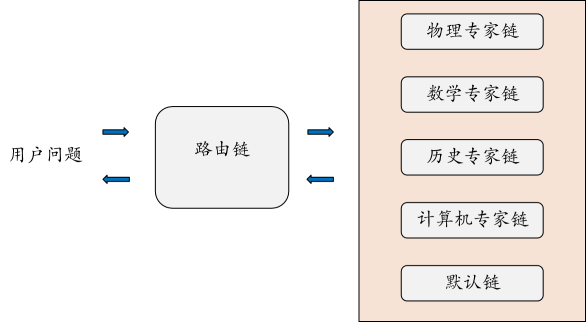

In [ ]:
from langchain.chains.router import MultiPromptChain  #导入多提示链
from langchain.chains.router.llm_router import LLMRouterChain,RouterOutputParser
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain    #导入LLM链。
from langchain.prompts import ChatPromptTemplate

llm = ChatOpenAI(model_name=model_name, temperature=0, openai_api_key=openai_api_key)

In [ ]:
#### 目标链提示模板

#第一个提示适合回答物理问题
physics_template = """你是一个非常聪明的物理专家。 \
你擅长用一种简洁并且易于理解的方式去回答问题。\
当你不知道问题的答案时，你承认\
你不知道.

这是一个问题:
{input}"""


#第二个提示适合回答数学问题
math_template = """你是一个非常优秀的数学家。 \
你擅长回答数学问题。 \
你之所以如此优秀， \
是因为你能够将棘手的问题分解为组成部分，\
回答组成部分，然后将它们组合在一起，回答更广泛的问题。

这是一个问题：
{input}"""


#第三个适合回答历史问题
history_template = """你是以为非常优秀的历史学家。 \
你对一系列历史时期的人物、事件和背景有着极好的学识和理解\
你有能力思考、反思、辩证、讨论和评估过去。\
你尊重历史证据，并有能力利用它来支持你的解释和判断。

这是一个问题:
{input}"""


#第四个适合回答计算机问题
computerscience_template = """ 你是一个成功的计算机科学专家。\
你有创造力、协作精神、\
前瞻性思维、自信、解决问题的能力、\
对理论和算法的理解以及出色的沟通技巧。\
你非常擅长回答编程问题。\
你之所以如此优秀，是因为你知道  \
如何通过以机器可以轻松解释的命令式步骤描述解决方案来解决问题，\
并且你知道如何选择在时间复杂性和空间复杂性之间取得良好平衡的解决方案。

这还是一个输入：
{input}"""


In [ ]:
#### 目标链名称、描述、提示模板
prompt_infos = [
    {
        "名字": "物理学",
        "描述": "擅长回答关于物理学的问题",
        "提示模板": physics_template
    },
    {
        "名字": "数学",
        "描述": "擅长回答数学问题",
        "提示模板": math_template
    },
    {
        "名字": "历史",
        "描述": "擅长回答历史问题",
        "提示模板": history_template
    },
    {
        "名字": "计算机科学",
        "描述": "擅长回答计算机科学问题",
        "提示模板": computerscience_template
    }
]


In [ ]:
#### 构造目标链
destination_chains = {}
for p_info in prompt_infos:
    name = p_info["名字"]
    prompt_template = p_info["提示模板"]
    prompt = ChatPromptTemplate.from_template(template=prompt_template)
    chain = LLMChain(llm=llm, prompt=prompt)
    destination_chains[name] = chain

destinations = [f"{p['名字']}: {p['描述']}" for p in prompt_infos]
destinations_str = "\n".join(destinations)

In [ ]:
destinations

['物理学: 擅长回答关于物理学的问题', '数学: 擅长回答数学问题', '历史: 擅长回答历史问题', '计算机科学: 擅长回答计算机科学问题']

In [ ]:
#### 构造默认链
default_prompt = ChatPromptTemplate.from_template("{input}")
default_chain = LLMChain(llm=llm, prompt=default_prompt)

In [ ]:
#### 多提示路由模板
MULTI_PROMPT_ROUTER_TEMPLATE = """给语言模型一个原始文本输入，\
让其选择最适合输入的模型提示。\
系统将为您提供可用提示的名称以及最适合改提示的描述。\
如果你认为修改原始输入最终会导致语言模型做出更好的响应，\
你也可以修改原始输入。


<< 格式 >>
返回一个带有JSON对象的markdown代码片段，该JSON对象的格式如下：
```json
{{{{
    "destination": 字符串 \ 使用的提示名字或者使用 "DEFAULT"
    "next_inputs": 字符串 \ 原始输入的改进版本
}}}}



记住：“destination”必须是下面指定的候选提示名称之一，\
或者如果输入不太适合任何候选提示，\
则可以是 “DEFAULT” 。
记住：如果您认为不需要任何修改，\
则 “next_inputs” 可以只是原始输入。

<< 候选提示 >>
{destinations}

<< 输入 >>
{{input}}

<< 输出 (记得要包含 ```json)>>

样例:
<< 输入 >>
"什么是黑体辐射?"
<< 输出 >>
```json
{{{{
    "destination": 字符串 \ 使用的提示名字或者使用 "DEFAULT"
    "next_inputs": 字符串 \ 原始输入的改进版本
}}}}

"""


In [ ]:
#### 构造路由链
router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(
    destinations=destinations_str
)
router_prompt = PromptTemplate(
    template=router_template,
    input_variables=["input"],
    output_parser=RouterOutputParser(),
)

router_chain = LLMRouterChain.from_llm(llm, router_prompt)

In [ ]:
#### 整体路由链
chain = MultiPromptChain(router_chain=router_chain,  # 路由链
              destination_chains=destination_chains,  # 目标链
              default_chain=default_chain,  # 默认链
              verbose=True
             )

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
chain.run("你好")



> Entering new MultiPromptChain chain...
None: {'input': '你好'}
> Finished chain.


'你好！有什么可以帮助你的吗？'

# 2.5 代理机制

使用LangChain内置工具

In [ ]:
from langchain.agents import load_tools, initialize_agent
from langchain.agents import AgentType
from langchain.chat_models import ChatOpenAI

In [ ]:
llm = ChatOpenAI(model_name=model_name, temperature=0, openai_api_key=openai_api_key)

tools = load_tools(
    ["llm-math", "wikipedia"],
    llm=llm
)

agent= initialize_agent(
    tools,
    llm,
    agent=AgentType.CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    handle_parsing_errors=True,
    verbose=True
)

In [ ]:
question = "10的3次方是多少？"
agent(question)



> Entering new AgentExecutor chain...
Thought: This is a simple math question that can be easily solved using a calculator.

Action:
```
{
  "action": "Calculator",
  "action_input": "10^3"
}
```


Observation: Answer: 1000
Thought:Final Answer: 1000

> Finished chain.


{'input': '10的3次方是多少？', 'output': '1000'}

自定义工具

In [ ]:
# 导入tool函数装饰器
from langchain.agents import tool
from datetime import date

@tool
def time(text: str) -> str:
    """
    返回今天的日期，用于任何需要知道今天日期的问题。\
    输入应该总是一个空字符串，\
    这个函数将总是返回今天的日期，任何日期计算应该在这个函数之外进行。
    """
    return str(date.today())

llm = ChatOpenAI(model_name="gpt-4", temperature=0.0, openai_api_key=openai_api_key)

# 初始化代理
agent = initialize_agent(
    tools=[time] + tools,
    llm=llm,
    agent=AgentType.CHAT_ZERO_SHOT_REACT_DESCRIPTION,  # 代理类型
    handle_parsing_errors=True, # 处理解析错误
    verbose=True
)

In [ ]:
agent("gpt是哪个公司发明的？")



> Entering new AgentExecutor chain...
Thought: GPT是由OpenAI发明的。我可以使用wikipedia工具来确认这个信息。
Action:
```
{
  "action": "wikipedia",
  "action_input": "GPT"
}
```
Observation: Page: ChatGPT
Summary: ChatGPT is a generative artificial intelligence chatbot developed by OpenAI and launched in 2022. It is currently based on the GPT-4o large language model (LLM). ChatGPT can generate human-like conversational responses and enables users to refine and steer a conversation towards a desired length, format, style, level of detail, and language. It is credited with accelerating the AI boom, which has led to ongoing rapid investment in and public attention to the field of artificial intelligence (AI). Some observers have raised concern about the potential of ChatGPT and similar programs to displace human intelligence, enable plagiarism, or fuel misinformation.
By January 2023, ChatGPT had become what was then the fastest-growing consumer software application in history, gaining over 100 million users

{'input': 'gpt是哪个公司发明的？', 'output': 'GPT是由OpenAI发明的。'}

# 2.7 搭建基于本地知识库的问答系统

In [ ]:

markdown_document = """
# 摘要：
主流的seq2seq模型是基于包含了编码器和解码器的复杂循环神网络或者卷积神经网络来实现的。表现最好的模型还通过注意力机制将编码器和解码器相连接。我们提出了一种新的简单的网络架构-Transformer，仅基于注意力机制，完全摒弃了循环和卷积。在两个机器翻译任务上的实验表明，这些模型在质量上表现更优秀，同时更易于并行化，且训练时间明显缩短。我们的模型在WMT2014英德翻译任务上取得了28.4BLEU的成绩，相比现有最好的结果（包括集成模型），提高了2个BLEU。在WMT2014英法翻译任务上，我们的模型仅在8个GPU上训练了3.5天，在训练成本远低于文献中最佳模型的情部下，实现了新的单模型BLEU分数最高的记录，达到41.8。我们证明了模型适用于其他任务，并成功将其应用于英语成分分析，包括大量和有限的训练数据。

# 1  引言
循环神经网络（Recurrent neural networks），长短时记忆网络（Long shot-term memory）和门控循环网络（Gated recurrent neural networks）已经被确认为序列建模和转导问题（例如语言建模和机器翻译）中的最先进方法。自那时以来，已经进行了大量工作来推动循环语言模型和编码器-解码器架构的发展。
循环模型通常根据输入和输出序列中的符号位置分解计算。将位置与计算时间齐步，它们将生成一系列隐藏状ht，作为先前隐藏状态ht-1和位置t的输入函数。这种固有的顺序性质使得在训练时不能并行化，而并行化在句子较长时是非常重要的。最近的工作能过分解技巧和条件计算实现了显著的计算效率提高，同时在后一种情况下提高了模型性能。但是，顺序计算的基本限制仍然存在。

在各种任务中，注意力机制已经成为引人入胜的序列和转导模型中重要的组成部分，允许在输入和输出中不考虑它们这间的距离来建模。极少数情况以下除外，少数情况下，这种注意力机制通常与循环神经网络结合使用。

在这项工作中，我们提出了Transformer模型架构，它避免使用循环，而是完全注意力机制来描述输入和输出的全局依赖关系。Transformer允许更多的并行化，并且在使用八个P100GPU进行为期仅十二个小时的训练后，可以达到翻译质量的新水平。
# 2  背景介绍：
减少顺序计算的目标也是Extended Neural GPU [16]、ByteNet [18]和ConvS2S [9]的基础，它们都使用卷积神经网络作为基本构建块，在所有输入和输出位置上并行计算隐藏表示。在这些模型中，将来自两个任意输入或输出位置的信号相关联所需的操作数量随着位置之间的距离而增加，ConvS2S的增长是线性的，ByteNet的增长是对数的。这使得学习远距离位置之间的依赖关系更加困难[12]。在Transformer中，这被减少为一定数量的操作，尽管由于平均注意加权位置而导致有效分辨率降低，我们通过多头注意力在第3.2节中描述的方法来抵消这种效应。

“自注意力”（有时也称为“内部注意力”）是深度学习模型中的一种技术，它能够关注序列中不同位置，以计算序列的表示。这与传统的注意力机制不同，后者通常涉及关注不同的上下文部分，而自注意力则可以关注序列本身的不同部分。自注意力机制已经成功地应用于许多任务，包括阅读 理解、抽象汇总、文本蕴含和学习无关的句子表示。

端到端记已网络是基于递归注意力机制而不是序列对齐递归，并已被证明在简单语言问答和语言建模任务中表现良好。

据我们所知，Transformer是第一个完全依靠自注意力机制计算输入和输出表示而不使用序列对齐RNN或卷积的传导模型。在接下来的章节中，我们将描述Transforer，阐述自注意力的动机，并讨论它相对于[17，18]和[9]等模型的优势。
# 3  模型架构++
大多数有竞争力的神经序列传导模型都具有编码器-解码器结构[5， 2， 35]。在这里，编码器将符号表示的输入序列x=（x1, ..., xn）映射到连续表示的z=（z1, .., zn）。给定z，解码器然后一次生成一个符号输出序列（y1, ..., ym）。在每一步，模型都是自回归的，在生成下一个符号时，使用先前生成的符号作为额外的输入。
## 3.1  编码器和解码器堆栈
编码器：编码器由N=6个相同的层组成。每个层有两个子层。第一个是多头自注意力机制，第二个是简单的逐位置全连接前馈网络。我们在两个子层周围采用残差连接【11】，然后进行归一化【1】。也就是说，每个子层的输出是LayerNorm(x+Sublayer(x))，其中Sublayer(x)是子层本身实现的函数。为了方便这些残差连接，模型中的所有以及嵌入层都产生dmodel=512维的输出。

解码器：解码器也是由N=6相同的层组成。除了每个编码器层中的两个子支之外，解码器还插入了第三个子层，该子层在编码器堆栈的输出上执行多头注意力。与编码器类似，我们在每个子层周围采用残差连接，然后进行层归一化。我们还修改了解码器堆栈中的自注意力子层，以防止关注后续位置。这种掩码，加上输出嵌入偏移一个位置，确保位置i的预测只依赖于小于i位置的已知输出。

## 3.2  注意力
一个注意力函数可以被描述为将一个查询和组键-值对映到一个输出，其中查询、键、值和输出都是向量。蝓出被计算为值的加权和，其中分配给每个值的权重是由查询与相 应键的兼容性函数计算得出的。
### 3.2.1  缩放点注意力
我们称这种特定的注意力为“缩放点注意力”。输入由维度为dk的查询和键以及维度为dv的值组成。我们计算查询和所有键的点积，将每个点积除以√dk，并应用softmax函数以获得值的权重。

两种最常用的注意力函数是加和注意力【2】和点积（乘法）注意力。点积注意力与我们的算法相同，只是缩放因子为1/√dk。加和注意力使用单隐藏层的前馈网络计算兼容函数。虽然两者理论复杂度上相似，但在实践中，点积注意力更快速和更节省空间，因为它可以使用高度优化的矩阵乘法代码来实现。

当dk的值较小的时候，这两种机制的性能相似，但是在较大的dk值下，加法注意力优于没有缩放的点积注意力【3】。我们怀疑在dk值较大的情况下，点积的结果变得非常大，将softmax函数推到其梯度极小的区域。为了抵消这种影响，我们将点积结果缩放1/√dk。
### 3.2.2  多头注意力
我们发现，与其使用一个dmodel维度的键、值和查询来执行单个注意力函数，通过将查询、键和值分别线性投影到dk、dk和dv维度，会更加有益。对每一组线性投影的查询、键和值，我们进行并行的注意力函数计算，生成dv维度的输出。这些值被连接在一起，并再次进行投影，最终生成最终值。

多头注意力机制允许模型在不同的位置同时关注来自不同表示子空间的信息。使用单个注意力头，平均化会抑制这种特性。
"""


In [ ]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQA,  ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.chat_models import ChatOpenAI
from langchain.text_splitter import MarkdownHeaderTextSplitter
from langchain_core.documents.base import Document
from langchain_core.messages.human import HumanMessage


class RagMahcine():
  def __init__(self,
          markdown_document=None,  # 外部markdown内容
          openai_api_key=None,
          model_name='gpt-3.5-turbo',  # 调用的gpt版本
          persist_directory='./chroma/llm/',  # 向量数据库存储地址
          chain_type='stuff',  # 检索问答链类型，stuff代表将检索到全部文档一次全部送入大模型
          search_type='similarity',  # 检索类型，similarity代表根据相似性进行检索
          k=3,  # 每次检索返回的文档数
          temperature=0  # 大模型回答的随机程度，0代表非常固定
    ):
    self.markdown_document = markdown_document
    self.openai_api_key = openai_api_key
    self.model_name = model_name
    self.persist_directory = persist_directory
    self.chain_type = chain_type
    self.search_type = search_type
    self.k = k
    self.temperature = temperature
    self.qa_chain = None
    self.init_machine()

  # 初始化rag流程
  def init_machine(self):
    markdown_document_inner = self.document_load(self.markdown_document)  # step1 文档加载
    para_splits = self.document_split(markdown_document_inner)  # step2 文档分隔
    vector_db = self.embedding_store(para_splits)  # step3 向量化与存储
    self.retrieval(vector_db)  # step4 构建检索问答链

  # step1 文档加载 文档加载可以有内存变量、磁盘文件、数据库等来源，本案例是从变量加载，代码有一定冗余，但保证了流程的标准化，方便逻辑修改复用。
  def document_load(self, markdown_document):
    return markdown_document

  # step2 文档分隔
  def document_split(self, markdown_document):
    headers_to_split_on = [
        ("#", "header_1"),
        ("##", "header_2"),
        ("###", "header_3"),
    ]
    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
    md_header_splits = markdown_splitter.split_text(markdown_document)
    para_splits = []
    for md_head in md_header_splits:
      me_head_metadata = md_head.metadata
      md_head_page_content = md_head.page_content
      md_head_page_content_paras = md_head_page_content.split('\n')
      for i in range(len(md_head_page_content_paras)):
        para_content = md_head_page_content_paras[i]
        para_metadata = me_head_metadata
        para_metadata['para'] = 'para_'+str(i)
        para_document = Document(page_content=para_content, metadata=para_metadata)
        para_splits.append(para_document)
    return para_splits

  # step3 向量化与存储
  def embedding_store(self, para_splits):
    embeddings = OpenAIEmbeddings(api_key=self.openai_api_key)
    vector_db = Chroma.from_documents(
      documents=para_splits,
      embedding=embeddings,
      persist_directory=self.persist_directory
    )
    return vector_db

  # step4 构建检索问答链
  def retrieval(self, vector_db):
    retriever = vector_db.as_retriever(search_type=self.search_type, search_kwargs={"k": self.k})
    memory = ConversationBufferMemory(
      memory_key="chat_history", # 与 prompt 的输入变量保持一致。
      return_messages=True # 将以消息列表的形式返回聊天记录，而不是单个字符串
    )
    self.qa_chain = ConversationalRetrievalChain.from_llm(
      llm=ChatOpenAI(model_name=self.model_name, temperature=self.temperature, openai_api_key=self.openai_api_key),
      chain_type=self.chain_type,
      retriever=retriever,
      memory=memory,
    )

  # step5 问答
  def question_answer(self, question):
    result = self.qa_chain({"question": question})
    for message in result['chat_history']:
      if isinstance(message, HumanMessage):
        print('Human：', message.content)
      else:
        print('AI：', message.content)

In [ ]:
rag_machine = RagMahcine(markdown_document=markdown_document, openai_api_key=openai_api_key)

In [ ]:
rag_machine.question_answer(question='您在前面提到的英德任务上的28.4的指标是什么？')

Human： transfomer论文里英德翻译任务的bleu值是多少？
AI： Transformer模型在WMT2014英德翻译任务上取得了28.4BLEU的成绩。
Human： 请简要介绍以下transformer算法的原理
AI： Transformer算法是一个基于自注意力机制的模型，用于计算输入和输出表示，而不使用传统的序列对齐RNN或卷积结构。该算法避免了循环结构，完全依赖于注意力机制来捕捉输入和输出之间的全局依赖关系。这种结构允许更多的并行化，使得在相对较短的训练时间内，如使用八个P100GPU进行为期仅十二个小时的训练后，就可以达到翻译等任务的新水平质量。
Human： 您在前面提到的英德任务上的28.4的指标是什么？
AI： 在WMT2014英德翻译任务上，Transformer模型取得了28.4BLEU的成绩。
